In [152]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Standard library
import os
from math import ceil
from typing import Dict, List, Tuple
from functools import reduce

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.feature_selection import SelectKBest, RFE, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import average_precision_score, recall_score, precision_score
from sklearn.exceptions import NotFittedError
from imblearn.metrics import classification_report_imbalanced

# Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Hyperparameter tuning
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

import utils as ut
import joblib

## Global Settings

In [120]:
pipe_path = "../outputs/pipelines/"
model_path = "../outputs/models/"
plot_path = "../outputs/plots/"

folds = 5

seed = 12

tf.random.set_seed(seed)

## Data

In [139]:
train_X, train_y = (
    pd.read_parquet(
        "/Users/kenwu/Desktop/Python/Python for Machine Learning/tree_based_models/projects/bank_marketing_project/data/train_test/train_X.parquet"
    ),
    pd.read_parquet(
        "/Users/kenwu/Desktop/Python/Python for Machine Learning/tree_based_models/projects/bank_marketing_project/data/train_test/train_y.parquet"
    )
    .to_numpy()
    .ravel(),
)
test_X, test_y = (
    pd.read_parquet(
        "/Users/kenwu/Desktop/Python/Python for Machine Learning/tree_based_models/projects/bank_marketing_project/data/train_test/test_X.parquet"
    ),
    pd.read_parquet(
        "/Users/kenwu/Desktop/Python/Python for Machine Learning/tree_based_models/projects/bank_marketing_project/data/train_test/test_y.parquet"
    )
    .to_numpy()
    .ravel(),
)

In [140]:
train_X.shape, train_y.shape
test_X.shape, test_y.shape

((32950, 20), (32950,))

((8238, 20), (8238,))

## Hyperparameter Search 

In [6]:
# Search space
search_space = {
    # Recursive feature elimination hyperparameters
    "num_feat": hp.choice("n_features_to_select", [50, 60, 70, 80, 100, 120]),
    "step": hp.choice("step", [0.1, 0.2, 0.3, 0.4]),
    # Neural network hyperparameters
    "num_hidden_layers": hp.choice("num_layers", [1, 2, 3]),
    "dropout_rate": hp.uniform("rate", 0.2, 0.7),
    "num_of_units": hp.choice("num_units", [32, 64, 128]),
    "adam_learning_rate": hp.choice("learning_rate", [1e-2, 1e-3, 1e-4]),
    "num_epochs": hp.choice("epochs", [100, 150, 200]),
    "batch_size": hp.choice("batch_size", [32, 64, 128, 256, 512, 1024, 2048]),
}

### Objective Function

We want to maximize average precision score since it takes into account both recall and precision:

In [118]:
def objective(params: Dict):
    # Read in new data for each run of the optimization since pandas dataframes are mutable objects
    train_X, train_y = (
        pd.read_parquet(
            "/Users/kenwu/Desktop/Python/Python for Machine Learning/tree_based_models/projects/bank_marketing_project/data/train_test/train_X.parquet"
        ),
        pd.read_parquet(
            "/Users/kenwu/Desktop/Python/Python for Machine Learning/tree_based_models/projects/bank_marketing_project/data/train_test/train_y.parquet"
        )
        .to_numpy()
        .ravel(),
    )
    folds = 3

    print(params)

    # Stratified K-fold cross-validation
    skf = StratifiedKFold(n_splits=folds, shuffle=True)

    recall_scores = np.empty(folds)
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_X, train_y)):
        # Train and validation sets
        fold_train_X, fold_train_y = train_X.iloc[train_idx], train_y[train_idx]
        fold_val_X, fold_val_y = train_X.iloc[val_idx], train_y[val_idx]

        # Processing using fresh copies for every fold
        print(f"Start processing fold {fold + 1}...")
        preprocessor = joblib.load(pipe_path + "preprocessor.joblib")
        label_encoder = joblib.load(pipe_path + "label_encoder.joblib")
        # Fit and transform on training data
        fold_train_X = preprocessor.fit_transform(fold_train_X)
        fold_train_y = label_encoder.fit_transform(fold_train_y)
        # Transform validation data
        fold_val_X = preprocessor.transform(fold_val_X)
        fold_val_y = label_encoder.transform(fold_val_y)

        # Compute class weight
        print(
            "Original distribution of classes in training data:",
            np.unique(fold_train_y, return_counts=True)[1] / len(fold_train_y),
        )
        class_weights = compute_class_weight(
            class_weight="balanced", classes=np.unique(fold_train_y), y=fold_train_y
        )
        print("Class weights:", class_weights)

        # Recursive feature elimination (tuning number of features and step size)
        feature_selector = RFE(
            estimator=DecisionTreeClassifier(),
            n_features_to_select=int(params["num_feat"]),
            step=float(params["step"]),
        )
        fold_train_X = np.array(
            feature_selector.fit_transform(fold_train_X, fold_train_y)
        )
        fold_val_X = np.array(feature_selector.transform(fold_val_X))

        # Initialize bias
        neg, pos = np.bincount(fold_train_y)
        initial_bias = np.log([pos / neg])
        print("Initial bias:", initial_bias)

        # Early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_recall",
            verbose=1,
            patience=20,  # Number of epochs to wait before stopping
            mode="max",
            restore_best_weights=True,
        )

        # Modeling
        model = keras.Sequential(
            [keras.Input(shape=(fold_train_X.shape[1],), name="input_layer")]
        )

        if int(params["num_hidden_layers"]) == 1:
            model.add(
                keras.layers.Dense(
                    units=int(params["num_of_units"]),
                    activation="relu",
                    name="hidden_layer_1",
                )
            )
            model.add(keras.layers.Dropout(rate=float(params["dropout_rate"])))

        if int(params["num_hidden_layers"]) == 2:
            model.add(
                keras.layers.Dense(
                    units=int(params["num_of_units"]),
                    activation="relu",
                    name="hidden_layer_1",
                )
            )
            model.add(keras.layers.Dropout(rate=float(params["dropout_rate"])))
            model.add(
                keras.layers.Dense(
                    units=int(params["num_of_units"]),
                    activation="relu",
                    name="hidden_layer_2",
                )
            )
            model.add(keras.layers.Dropout(rate=float(params["dropout_rate"])))

        if int(params["num_hidden_layers"]) == 3:
            model.add(
                keras.layers.Dense(
                    units=int(params["num_of_units"]),
                    activation="relu",
                    name="hidden_layer_1",
                )
            )
            model.add(keras.layers.Dropout(rate=float(params["dropout_rate"])))
            model.add(
                keras.layers.Dense(
                    units=int(params["num_of_units"]),
                    activation="relu",
                    name="hidden_layer_2",
                )
            )
            model.add(keras.layers.Dropout(rate=float(params["dropout_rate"])))
            model.add(
                keras.layers.Dense(
                    units=int(params["num_of_units"]),
                    activation="relu",
                    name="hidden_layer_3",
                )
            )
            model.add(keras.layers.Dropout(rate=float(params["dropout_rate"])))

        # Use linear activation for numerical stability and initialize bias to the initial bias computed above
        model.add(
            keras.layers.Dense(
                units=1,
                activation="linear",
                bias_initializer=keras.initializers.Constant(value=initial_bias),
                name="output_layer",
            )
        )

        model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=float(params["adam_learning_rate"])
            ),
            loss=keras.losses.BinaryCrossentropy(
                from_logits=True
            ),  # Obtain logits from output layer, which we can transform to probabilities using sigmoid
            metrics=[
                keras.metrics.Precision(name="precision"),
                keras.metrics.Recall(name="recall"),
                keras.metrics.AUC(name="auc"),
                keras.metrics.AUC(name="prc", curve="PR"),
            ],
        )

        model.fit(
            x=fold_train_X,
            y=fold_train_y,
            batch_size=int(params["batch_size"]),
            epochs=int(params["num_epochs"]),
            callbacks=[early_stopping],
            validation_data=(fold_val_X, fold_val_y),
            class_weight={0: class_weights[0], 1: class_weights[1]},
        )

        # Out of fold predictions
        logits = model.predict(fold_val_X)
        pred_y = tf.math.sigmoid(logits).numpy().ravel()

        # Compute metrics
        recall_scores[fold] = recall_score(fold_val_y, pred_y > 0.5, average="weighted")

    avg_recall_scores = np.mean(recall_scores)

    print(f"Average recall score across all folds: {avg_recall_scores}")

    return {
        "loss": -avg_recall_scores,
        "status": STATUS_OK,
    }  # Minimize negative average precision score is the same as maximizing the average precision score

### Minimization 

In [36]:
trials = Trials()

best_params = fmin(
    fn=objective, space=search_space, algo=tpe.suggest, max_evals=25, trials=trials
)

{'adam_learning_rate': 0.001, 'batch_size': 1024, 'dropout_rate': 0.5710152340612819, 'num_epochs': 100, 'num_feat': 80, 'num_hidden_layers': 2, 'num_of_units': 64, 'step': 0.1}
Start processing fold 1...                            
Original distribution of classes in training data:    
[0.88737139 0.11262861]                               
Class weights:                                        
[0.56346193 4.43936944]                               
Initial bias:                                         
[-2.06416785]                                         
Epoch 1/100                                           

22/22 [==============================] - 1s 21ms/step - loss: 1403.0018 - precision: 0.1104 - recall: 0.4665 - auc: 0.4946 - prc: 0.1111 - val_loss: 357.7650 - val_precision: 0.1219 - val_recall: 0.9289 - val_auc: 0.5396 - val_prc: 0.1216

Epoch 2/100                                           

22/22 [==============================] - 0s 8ms/step - loss: 608.7811 - precision: 0.

In [37]:
best_params

{'batch_size': 4,
 'epochs': 1,
 'learning_rate': 0,
 'n_features_to_select': 3,
 'num_layers': 1,
 'num_units': 0,
 'rate': 0.5214801081131133,
 'step': 1}

In [91]:
best_params = {
    "adam_learning_rate": 0.0001,
    "batch_size": 128,
    "dropout_rate": 0.5214801081131133,
    "num_epochs": 100,
    "num_feat": 80,
    "num_hidden_layers": 2,
    "num_of_units": 64,
    "step": 0.2,
}
best_params

{'adam_learning_rate': 0.0001,
 'batch_size': 128,
 'dropout_rate': 0.5214801081131133,
 'num_epochs': 100,
 'num_feat': 80,
 'num_hidden_layers': 2,
 'num_of_units': 64,
 'step': 0.2}

## K-Fold Cross Validation

In [119]:
# Out-of-fold predictions
oof_pred = {}
# History callback objects
hist_objs = {}
# Stratified K-fold cross-validation
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_X, train_y)):
    # Train and validation sets
    fold_train_X, fold_train_y = train_X.iloc[train_idx], train_y[train_idx]
    fold_val_X, fold_val_y = train_X.iloc[val_idx], train_y[val_idx]

    # Processing using fresh copies for every fold
    print(f"Start processing fold {fold + 1}...")
    preprocessor = joblib.load(pipe_path + "preprocessor.joblib")
    label_encoder = joblib.load(pipe_path + "label_encoder.joblib")
    # Fit and transform on training data
    fold_train_X = preprocessor.fit_transform(fold_train_X)
    fold_train_y = label_encoder.fit_transform(fold_train_y)
    # Transform validation data
    fold_val_X = preprocessor.transform(fold_val_X)
    fold_val_y = label_encoder.transform(fold_val_y)
    # Write preprocessor and label encoder to disk
    joblib.dump(preprocessor, pipe_path + f"preprocessor_fold_{fold + 1}.joblib")
    joblib.dump(label_encoder, pipe_path + f"label_encoder_fold_{fold + 1}.joblib")

    # Compute class weight
    print(
        "Original distribution of classes in training data:",
        np.unique(fold_train_y, return_counts=True)[1] / len(fold_train_y),
    )
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(fold_train_y), y=fold_train_y
    )
    print("Class weights:", class_weights)

    # Recursive feature elimination (tuning number of features and step size)
    feature_selector = RFE(
        estimator=DecisionTreeClassifier(),
        n_features_to_select=best_params["num_feat"],
        step=best_params["step"],
    )
    fold_train_X = np.array(feature_selector.fit_transform(fold_train_X, fold_train_y))
    fold_val_X = np.array(feature_selector.transform(fold_val_X))
    # Write feature selector to disk
    joblib.dump(
        feature_selector, pipe_path + f"feature_selector_fold_{fold + 1}.joblib"
    )

    # Initialize bias
    neg, pos = np.bincount(fold_train_y)
    initial_bias = np.log([pos / neg])
    print("Initial bias:", initial_bias)

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_recall",
        verbose=1,
        patience=10,  # Number of epochs to wait before stopping
        mode="max",
        restore_best_weights=True,
    )

    # Modeling
    model = keras.Sequential(
        [
            keras.Input(shape=(fold_train_X.shape[1],), name="input_layer"),
            keras.layers.Dense(
                units=best_params["num_of_units"],
                activation="relu",
                name="hidden_layer_1",
            ),
            keras.layers.Dropout(rate=best_params["dropout_rate"]),
            keras.layers.Dense(
                units=best_params["num_of_units"],
                activation="relu",
                name="hidden_layer_2",
            ),
            keras.layers.Dropout(rate=best_params["dropout_rate"]),
            keras.layers.Dense(
                units=1,
                activation="linear",
                bias_initializer=keras.initializers.Constant(value=initial_bias),
                name="output_layer",
            ),
        ]
    )
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=best_params["adam_learning_rate"]
        ),
        loss=keras.losses.BinaryCrossentropy(
            from_logits=True
        ),  # Obtain logits from output layer, which we can transform to probabilities using sigmoid
        metrics=[
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.AUC(name="auc"),
            keras.metrics.AUC(name="prc", curve="PR"),
        ],
    )

    history = model.fit(
        x=fold_train_X,
        y=fold_train_y,
        batch_size=best_params["batch_size"],
        epochs=best_params["num_epochs"],
        callbacks=[early_stopping],
        validation_data=(fold_val_X, fold_val_y),
        class_weight={0: class_weights[0], 1: class_weights[1]},
    )
    hist_objs[f"fold {fold + 1}"] = history
    # Write model to disk
    model.save(model_path + f"model_fold_{fold + 1}.h5")

    # Out of fold predictions
    logits = model.predict(fold_val_X)
    pred_y = tf.math.sigmoid(logits).numpy().ravel()
    oof_pred[f"fold {fold + 1}"] = (fold_val_y, pred_y)

    print(
        f"Fold {fold + 1} recall using 0.5 as threshold:",
        recall_score(fold_val_y, pred_y > 0.5),
    )

Start processing fold 1...


['../outputs/pipelines/preprocessor_fold_1.joblib']

['../outputs/pipelines/label_encoder_fold_1.joblib']

Original distribution of classes in training data: [0.88732929 0.11267071]
Class weights: [0.56348867 4.43771044]


['../outputs/pipelines/feature_selector_fold_1.joblib']

Initial bias: [-2.06374663]
Epoch 1/100
206/206 [==============================] - 4s 7ms/step - loss: 1297.5603 - precision: 0.1200 - recall: 0.5236 - auc: 0.5180 - prc: 0.1178 - val_loss: 181.8831 - val_precision: 0.1487 - val_recall: 0.7318 - val_auc: 0.6006 - val_prc: 0.1431
Epoch 2/100
206/206 [==============================] - 1s 3ms/step - loss: 811.8292 - precision: 0.1198 - recall: 0.5138 - auc: 0.5172 - prc: 0.1176 - val_loss: 166.2541 - val_precision: 0.1344 - val_recall: 0.8383 - val_auc: 0.5769 - val_prc: 0.1325
Epoch 3/100
206/206 [==============================] - 1s 3ms/step - loss: 523.0796 - precision: 0.1203 - recall: 0.5125 - auc: 0.5184 - prc: 0.1180 - val_loss: 160.6280 - val_precision: 0.1283 - val_recall: 0.8854 - val_auc: 0.5612 - val_prc: 0.1273
Epoch 4/100
206/206 [==============================] - 1s 3ms/step - loss: 359.0017 - precision: 0.1216 - recall: 0.5141 - auc: 0.5212 - prc: 0.1189 - val_loss: 102.2016 - val_precision: 0.1232 - val_recall: 0.8962 - v

['../outputs/pipelines/preprocessor_fold_2.joblib']

['../outputs/pipelines/label_encoder_fold_2.joblib']

Original distribution of classes in training data: [0.88732929 0.11267071]
Class weights: [0.56348867 4.43771044]


['../outputs/pipelines/feature_selector_fold_2.joblib']

Initial bias: [-2.06374663]
Epoch 1/100
206/206 [==============================] - 3s 7ms/step - loss: 1263.0703 - precision: 0.1202 - recall: 0.4842 - auc: 0.5170 - prc: 0.1177 - val_loss: 73.5673 - val_precision: 0.1306 - val_recall: 0.3423 - val_auc: 0.5266 - val_prc: 0.1224
Epoch 2/100
206/206 [==============================] - 1s 3ms/step - loss: 805.6379 - precision: 0.1161 - recall: 0.5051 - auc: 0.5084 - prc: 0.1151 - val_loss: 95.1959 - val_precision: 0.1294 - val_recall: 0.8558 - val_auc: 0.5625 - val_prc: 0.1280
Epoch 3/100
206/206 [==============================] - 1s 4ms/step - loss: 545.0756 - precision: 0.1140 - recall: 0.5010 - auc: 0.5032 - prc: 0.1136 - val_loss: 75.7082 - val_precision: 0.1330 - val_recall: 0.8221 - val_auc: 0.5711 - val_prc: 0.1310
Epoch 4/100
206/206 [==============================] - 1s 4ms/step - loss: 368.7200 - precision: 0.1192 - recall: 0.5077 - auc: 0.5158 - prc: 0.1172 - val_loss: 26.0181 - val_precision: 0.1364 - val_recall: 0.6981 - val_a

['../outputs/pipelines/preprocessor_fold_3.joblib']

['../outputs/pipelines/label_encoder_fold_3.joblib']

Original distribution of classes in training data: [0.88732929 0.11267071]
Class weights: [0.56348867 4.43771044]


['../outputs/pipelines/feature_selector_fold_3.joblib']

Initial bias: [-2.06374663]
Epoch 1/100
206/206 [==============================] - 3s 7ms/step - loss: 1439.0500 - precision: 0.1132 - recall: 0.4401 - auc: 0.5011 - prc: 0.1130 - val_loss: 323.2617 - val_precision: 0.1257 - val_recall: 0.9272 - val_auc: 0.5543 - val_prc: 0.1252
Epoch 2/100
206/206 [==============================] - 1s 4ms/step - loss: 851.4413 - precision: 0.1191 - recall: 0.4778 - auc: 0.5146 - prc: 0.1170 - val_loss: 111.4346 - val_precision: 0.1272 - val_recall: 0.6523 - val_auc: 0.5423 - val_prc: 0.1243
Epoch 3/100
206/206 [==============================] - 1s 4ms/step - loss: 526.1037 - precision: 0.1196 - recall: 0.4781 - auc: 0.5157 - prc: 0.1173 - val_loss: 55.3521 - val_precision: 0.1391 - val_recall: 0.4946 - val_auc: 0.5537 - val_prc: 0.1305
Epoch 4/100
206/206 [==============================] - 1s 4ms/step - loss: 360.0629 - precision: 0.1180 - recall: 0.4798 - auc: 0.5122 - prc: 0.1163 - val_loss: 32.8921 - val_precision: 0.1435 - val_recall: 0.4178 - val

['../outputs/pipelines/preprocessor_fold_4.joblib']

['../outputs/pipelines/label_encoder_fold_4.joblib']

Original distribution of classes in training data: [0.88736722 0.11263278]
Class weights: [0.56346458 4.43920512]


['../outputs/pipelines/feature_selector_fold_4.joblib']

Initial bias: [-2.06412614]
Epoch 1/100
206/206 [==============================] - 3s 6ms/step - loss: 1879.4607 - precision: 0.1133 - recall: 0.4557 - auc: 0.5014 - prc: 0.1130 - val_loss: 188.9668 - val_precision: 0.1082 - val_recall: 0.7187 - val_auc: 0.4832 - val_prc: 0.1090
Epoch 2/100
206/206 [==============================] - 1s 4ms/step - loss: 1171.1753 - precision: 0.1166 - recall: 0.4853 - auc: 0.5094 - prc: 0.1154 - val_loss: 223.1548 - val_precision: 0.1205 - val_recall: 0.8358 - val_auc: 0.5306 - val_prc: 0.1199
Epoch 3/100
206/206 [==============================] - 1s 4ms/step - loss: 812.5278 - precision: 0.1151 - recall: 0.4894 - auc: 0.5058 - prc: 0.1143 - val_loss: 164.6973 - val_precision: 0.1289 - val_recall: 0.7927 - val_auc: 0.5561 - val_prc: 0.1271
Epoch 4/100
206/206 [==============================] - 1s 4ms/step - loss: 570.2003 - precision: 0.1163 - recall: 0.4941 - auc: 0.5089 - prc: 0.1152 - val_loss: 126.7549 - val_precision: 0.1318 - val_recall: 0.7900 - 

['../outputs/pipelines/preprocessor_fold_5.joblib']

['../outputs/pipelines/label_encoder_fold_5.joblib']

Original distribution of classes in training data: [0.88736722 0.11263278]
Class weights: [0.56346458 4.43920512]


['../outputs/pipelines/feature_selector_fold_5.joblib']

Initial bias: [-2.06412614]
Epoch 1/100
206/206 [==============================] - 3s 6ms/step - loss: 1586.2114 - precision: 0.1112 - recall: 0.4928 - auc: 0.4965 - prc: 0.1117 - val_loss: 263.9263 - val_precision: 0.1215 - val_recall: 0.9166 - val_auc: 0.5374 - val_prc: 0.1212
Epoch 2/100
206/206 [==============================] - 1s 4ms/step - loss: 922.7722 - precision: 0.1168 - recall: 0.4877 - auc: 0.5099 - prc: 0.1155 - val_loss: 138.9892 - val_precision: 0.1291 - val_recall: 0.8223 - val_auc: 0.5591 - val_prc: 0.1276
Epoch 3/100
206/206 [==============================] - 1s 4ms/step - loss: 614.6013 - precision: 0.1204 - recall: 0.4917 - auc: 0.5178 - prc: 0.1179 - val_loss: 64.4625 - val_precision: 0.1368 - val_recall: 0.6016 - val_auc: 0.5599 - val_prc: 0.1310
Epoch 4/100
206/206 [==============================] - 1s 4ms/step - loss: 418.6963 - precision: 0.1172 - recall: 0.4789 - auc: 0.5104 - prc: 0.1157 - val_loss: 66.3839 - val_precision: 0.1340 - val_recall: 0.6837 - val

### Performance Metrics

Average recall across all five folds using 0.5 as the threshold:

In [121]:
recall_scores = np.empty(shape=(folds,))
for ind, key in enumerate(oof_pred):
    recall_scores[ind] = recall_score(oof_pred[key][0], oof_pred[key][1] > 0.5)
np.mean(recall_scores)

0.89655291253859

Plot metrics for each of the models:

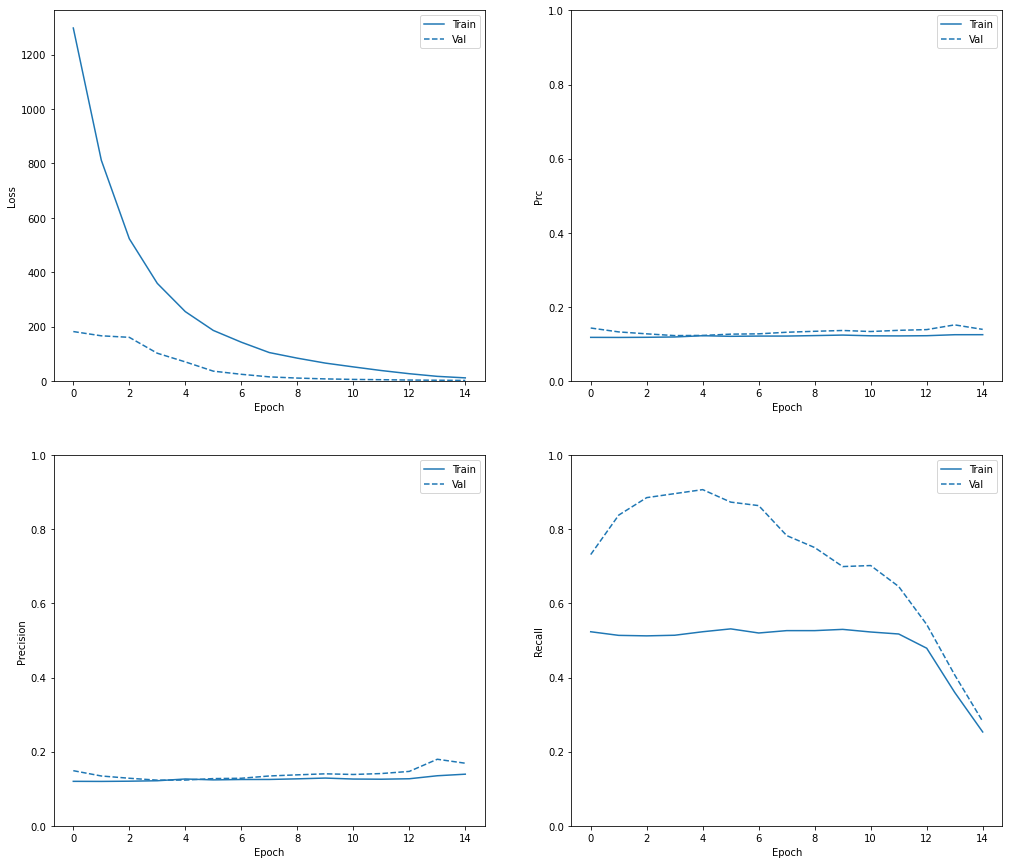

In [122]:
ut.plot_metrics(hist_objs["fold 1"])

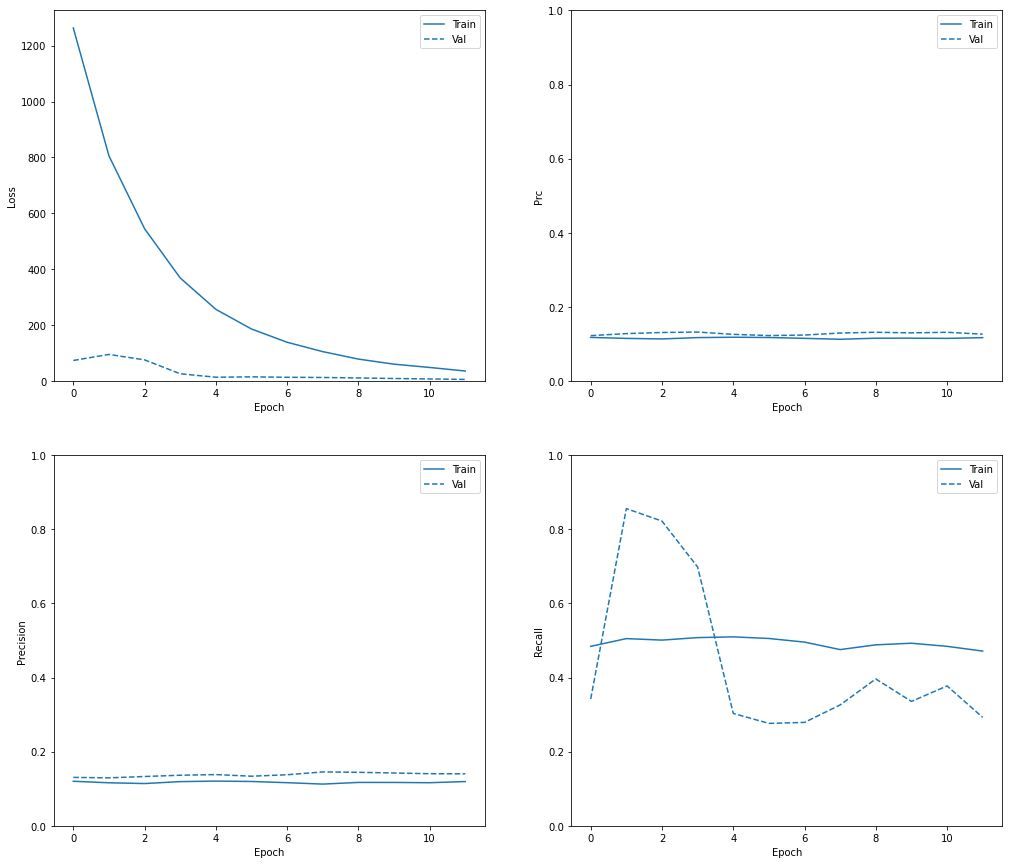

In [123]:
plot_metrics(hist_objs["fold 2"])

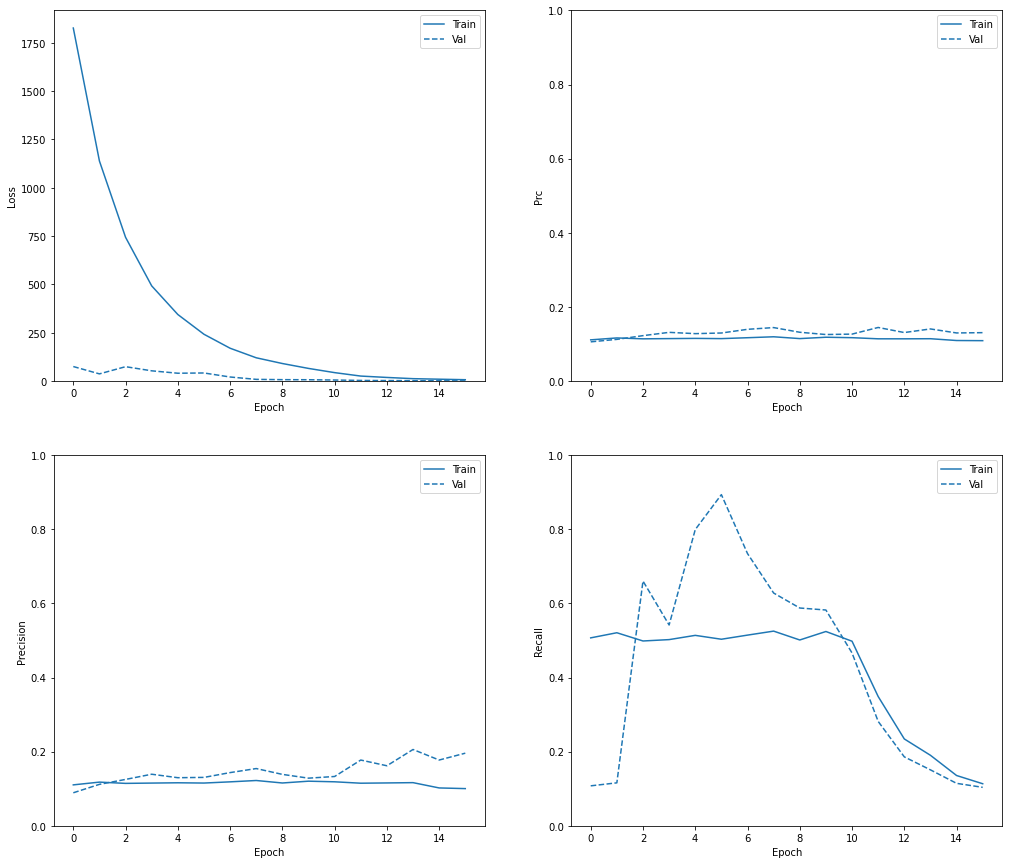

In [96]:
ut.plot_metrics(hist_objs["fold 3"])

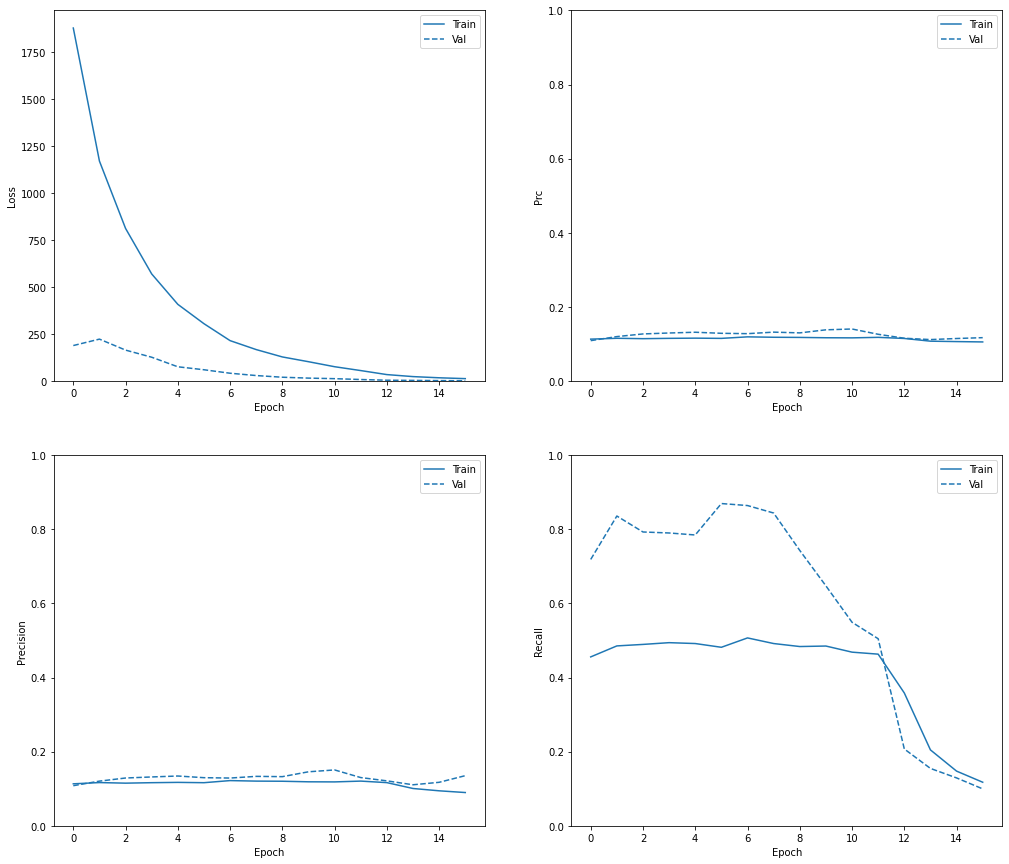

In [124]:
ut.plot_metrics(hist_objs["fold 4"])

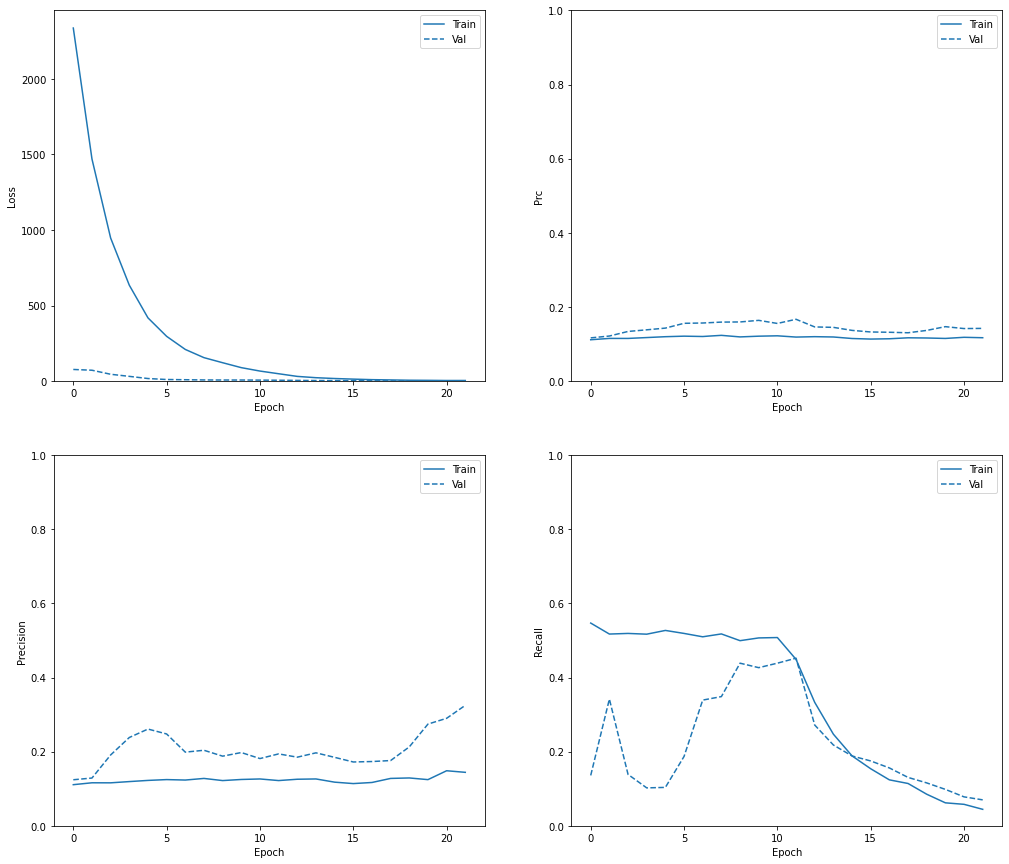

In [98]:
ut.plot_metrics(hist_objs["fold 5"])

Across all folds. The performance metrics on the validation set are generally better than those on the training set. This is mainly due to that the fact that we used dropout regularization, which does not take place in validation (non-training) mode. 

> A Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing time. They are reflected in the training time loss but not in the test time loss. Besides, the training loss that Keras displays is the average of the losses for each batch of training data, over the current epoch. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. This can bring the epoch-wise average down. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

### Confusion Matrix

Non-subscriber correctly identified as non-subscriber (True Negatives):  1061
Non-subscriber incorrectly identified as subscriber (False Positives):  4787
Subscriber incorrectly identified as non-subscriber (False Negatives):  68
Subscriber correctly identified as subscribers (True Positives):  674
Total subscribers identified:  742


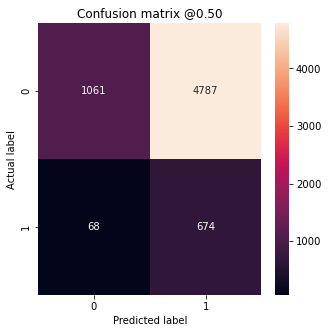

In [125]:
ut.plot_cm(oof_pred["fold 1"][0], oof_pred["fold 1"][1])

Non-subscriber correctly identified as non-subscriber (True Negatives):  1570
Non-subscriber incorrectly identified as subscriber (False Positives):  4278
Subscriber incorrectly identified as non-subscriber (False Negatives):  105
Subscriber correctly identified as subscribers (True Positives):  637
Total subscribers identified:  742


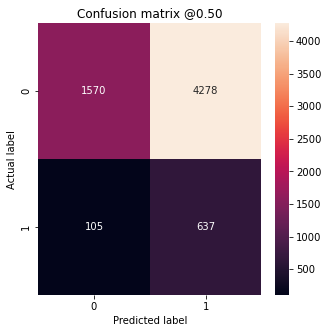

In [126]:
ut.plot_cm(oof_pred["fold 2"][0], oof_pred["fold 2"][1])

Non-subscriber correctly identified as non-subscriber (True Negatives):  1061
Non-subscriber incorrectly identified as subscriber (False Positives):  4787
Subscriber incorrectly identified as non-subscriber (False Negatives):  54
Subscriber correctly identified as subscribers (True Positives):  688
Total subscribers identified:  742


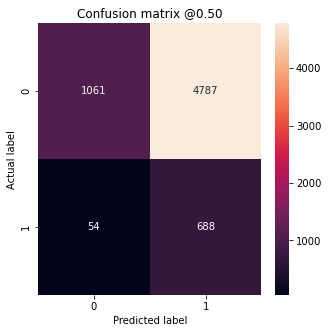

In [127]:
ut.plot_cm(oof_pred["fold 3"][0], oof_pred["fold 3"][1])

Non-subscriber correctly identified as non-subscriber (True Negatives):  1511
Non-subscriber incorrectly identified as subscriber (False Positives):  4336
Subscriber incorrectly identified as non-subscriber (False Negatives):  95
Subscriber correctly identified as subscribers (True Positives):  648
Total subscribers identified:  743


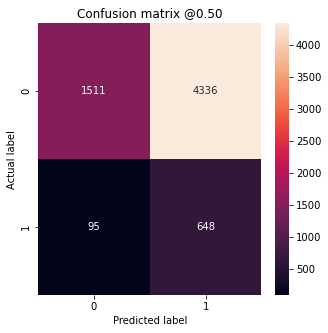

In [128]:
ut.plot_cm(oof_pred["fold 4"][0], oof_pred["fold 4"][1])

Non-subscriber correctly identified as non-subscriber (True Negatives):  920
Non-subscriber incorrectly identified as subscriber (False Positives):  4927
Subscriber incorrectly identified as non-subscriber (False Negatives):  62
Subscriber correctly identified as subscribers (True Positives):  681
Total subscribers identified:  743


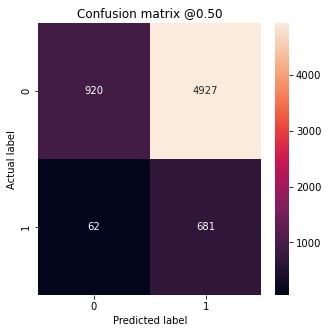

In [129]:
ut.plot_cm(oof_pred["fold 5"][0], oof_pred["fold 5"][1])

There is a severe trade-off between false positive and false negative. In increasing recall (true positive) and minimizing false negative (false negative), the classifier has significantly higher false positive rate--- non-subscribers may be receiving emails from the marketing team about deals.

### ROC Curve

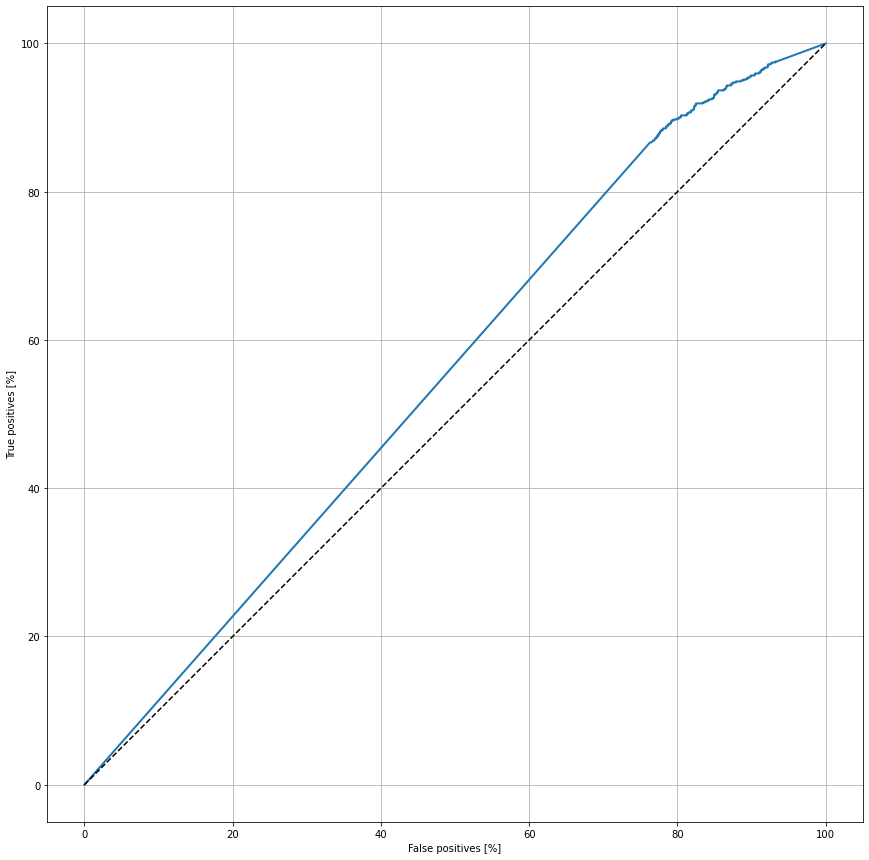

In [134]:
ut.plot_roc("Validation", oof_pred["fold 1"][0], oof_pred["fold 1"][1])

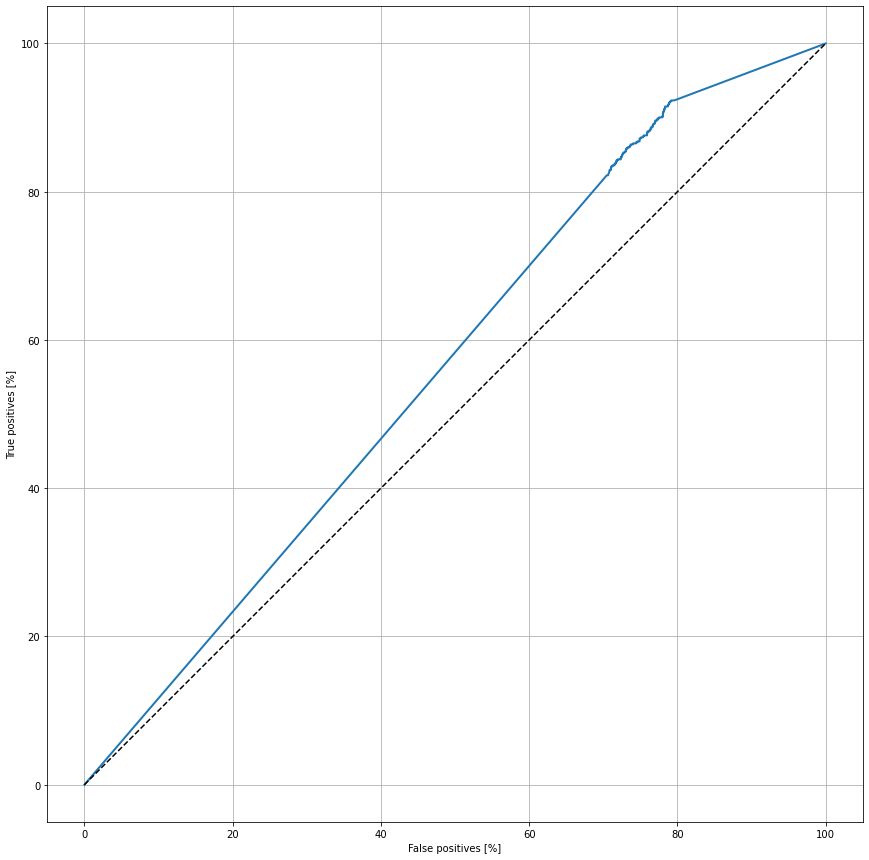

In [135]:
ut.plot_roc("Validation", oof_pred["fold 2"][0], oof_pred["fold 2"][1])

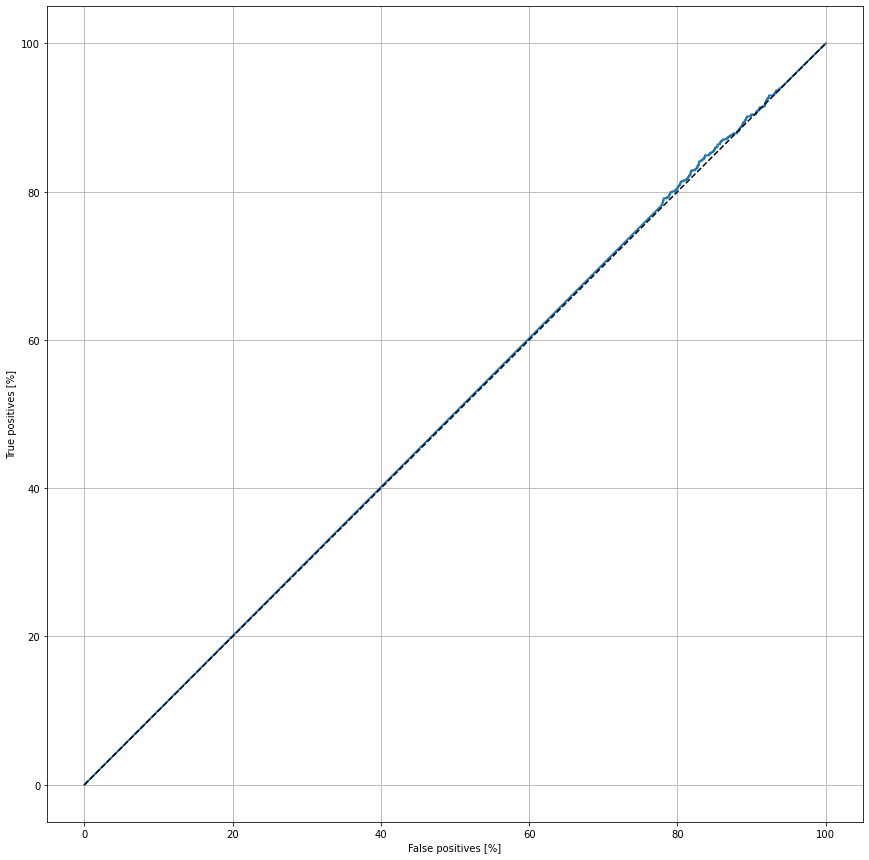

In [136]:
ut.plot_roc("Validation", oof_pred["fold 3"][0], oof_pred["fold 1"][1])

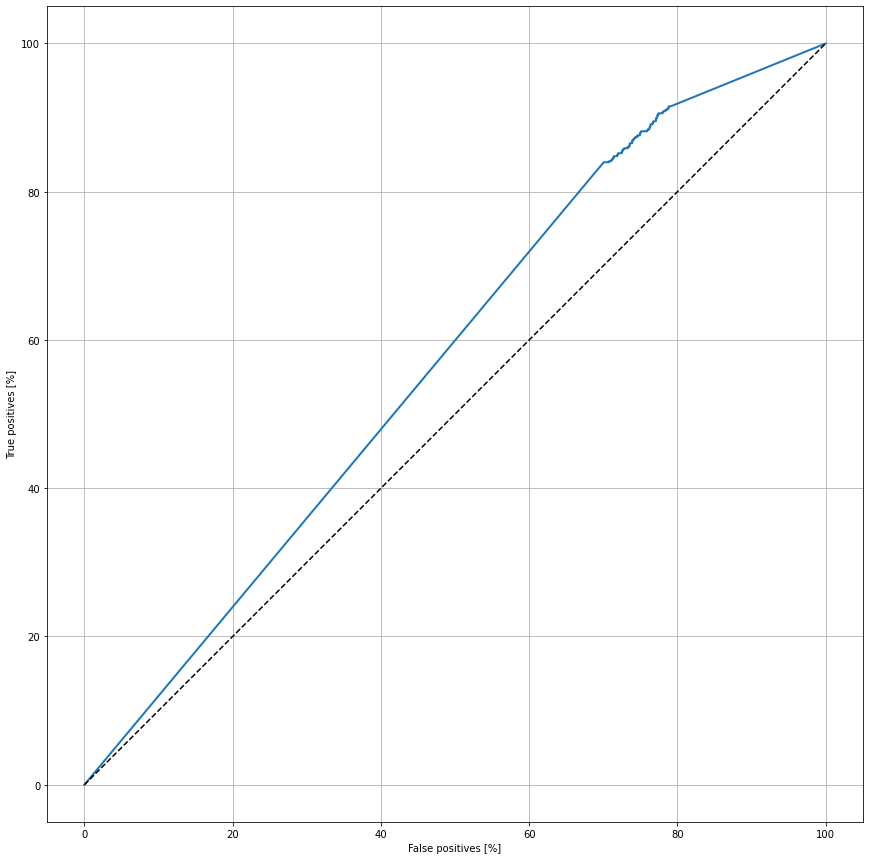

In [137]:
ut.plot_roc("Validation", oof_pred["fold 4"][0], oof_pred["fold 4"][1])

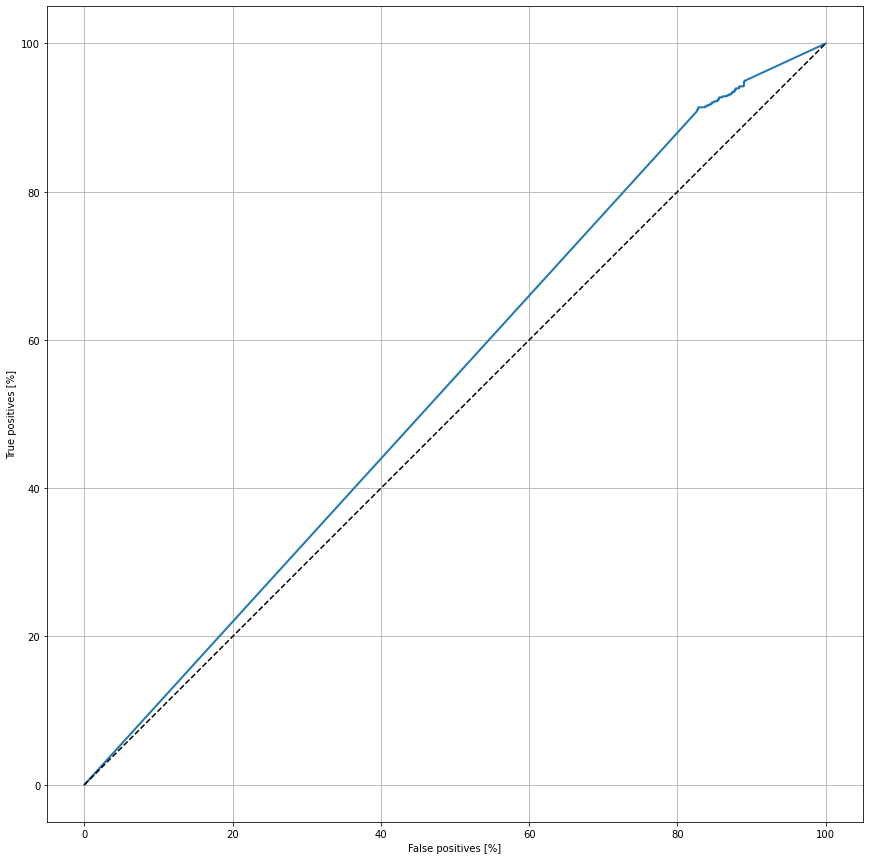

In [138]:
ut.plot_roc("Validation", oof_pred["fold 5"][0], oof_pred["fold 5"][1])

## Performance on Test Set

In [149]:
test_y = joblib.load(pipe_path + f"label_encoder.joblib").fit_transform(test_y)

In [147]:
avg_preds = np.zeros_like(test_y)

for fold in range(folds):
    # Load model
    model = keras.models.load_model(model_path + f"model_fold_{fold + 1}.h5")

    # Preprocessing and feature selection
    fold_X = joblib.load(pipe_path + f"preprocessor_fold_{fold + 1}.joblib").transform(
        test_X
    )
    fold_y = joblib.load(pipe_path + f"label_encoder_fold_{fold + 1}.joblib").transform(
        test_y
    )
    fold_X = np.array(
        joblib.load(pipe_path + f"feature_selector_fold_{fold + 1}.joblib").transform(
            fold_X
        )
    )

    # Make predictions
    logits = model.predict(fold_X)
    preds = tf.math.sigmoid(logits).numpy().ravel()
    # Element-wise addition
    avg_preds += preds

# Average predictions
avg_preds /= folds
avg_preds

258/258 [==============================] - 0s 629us/step


array([0.6, 1.0, 1.0, ..., 1.0, 0.5999924540519714, 1.0], dtype=object)

### Confusion Matrix

Non-subscriber correctly identified as non-subscriber (True Negatives):  1610
Non-subscriber incorrectly identified as subscriber (False Positives):  5700
Subscriber incorrectly identified as non-subscriber (False Negatives):  96
Subscriber correctly identified as subscribers (True Positives):  832
Total subscribers identified:  928


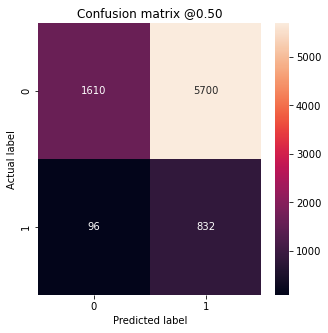

In [150]:
ut.plot_cm(test_y, avg_preds)

The recall score (true positive) is:

In [151]:
recall_score(test_y, avg_preds > 0.5)

0.896551724137931

The precision score (i.e., the ability of the classifier not to label as positive a sample that is negative):

In [153]:
precision_score(test_y, avg_preds > 0.5)

0.12737293325168403

The classifier is strong in its ability to find all the subscribers (which can be costly if they are mis-classified as non-subscribers); however, in doing so, the model is less precise (many more non-subscribers are incorrectly identified as subscribers).

### ROC Curve

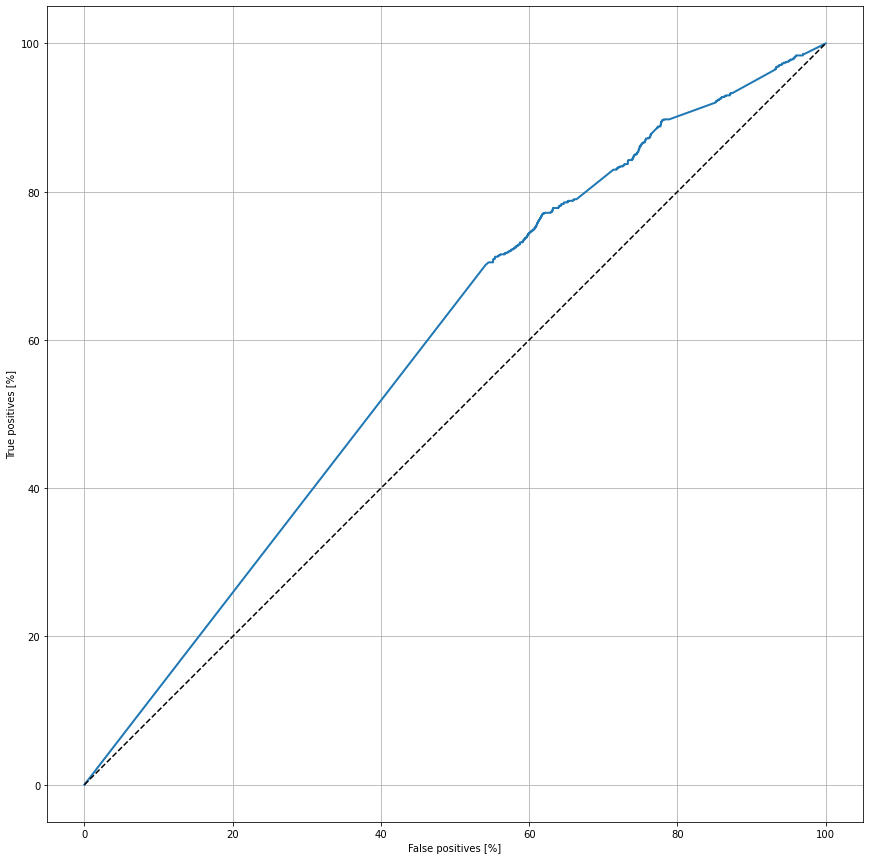

In [154]:
ut.plot_roc("Test", test_y, avg_preds)

### PRC Curve

In [157]:
test_y.sum() / len(test_y)

0.11264870114105366

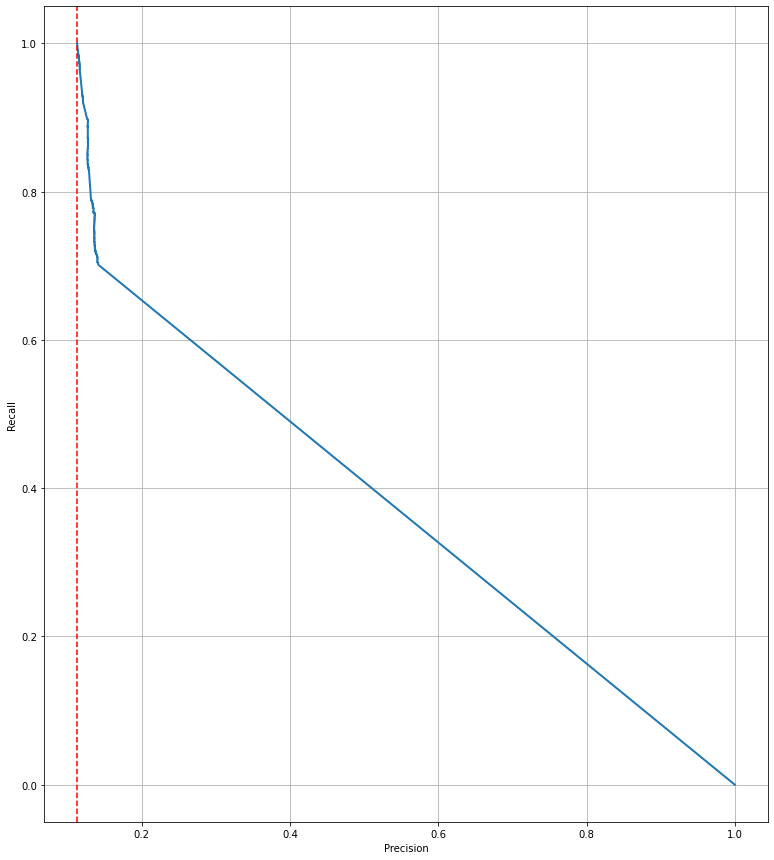

In [159]:
ut.plot_prc("Test", test_y, avg_preds)
plt.axvline(x=test_y.sum() / len(test_y), color="r", linestyle="--")

A model with perfect skill is depicted as a point at a coordinate of (1,1). A skillful model is represented by a curve that bows towards a coordinate of (1,1) or upper right corner. A no-skill classifier will be a vertical line on the plot with a precision that is proportional to the number of positive examples in the dataset.